In [1]:
import scanpy as sc
import os
import pandas as pd
import matplotlib as mpl
import sys
import numpy as np
import matplotlib.pyplot as plt
import diffxpy.api as de
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp

%reload_ext autoreload
%autoreload 2

mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

2024-04-15 09:25:28.612604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 09:25:34.550188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Full Data

In [2]:
#adata_full = sc.read_h5ad('../OrganoidAnalysis/integration/GBMOrganoids_scVIsurgery.h5ad')

In [3]:
adata_full = sc.read_h5ad('../../OrganoidAnalysis/integration/GBMOrganoids_scVIsurgery20240408.h5ad')

In [4]:
annotation_colors = {
    '+HYP2':'#840034',
    'preOPC': '#7befb2',
    'RG':'#ff9470',
    '+HYP1':'#C50F53',
    'AC1':'#2ecc71',
    'nIPC':'#FFF192',
    'OPC':'#89c4f4',
    'GBL':'#b9e670',
    'hAC':'#EDE8F3',
    'AC2':'#2ecc71',
    'FBL':'#9f5afd',
    'rAC':'#e3ba8f',
    'cOPC':'#038aff',
    'Unknown':'#efeff0',
}

In [5]:
'''adata_full.X = adata_full.raw.X

exp = pd.Categorical([l+'-'+c+'-'+t for l, c, t in zip(adata_full.obs.line, adata_full.obs.condition, adata_full.obs.time)])
adata_full.obs['Experiment'] = exp
cell_n = {e: (adata_full.obs['Experiment']==e).sum() for e in adata_full.obs['Experiment'].cat.categories}
organoid_size = np.array([cell_n[e] for e in adata_full.obs['Experiment']])
adata_full.X = adata_full.X / organoid_size[:,np.newaxis]
sc.pp.log1p(adata_full)'''

"adata_full.X = adata_full.raw.X\n\nexp = pd.Categorical([l+'-'+c+'-'+t for l, c, t in zip(adata_full.obs.line, adata_full.obs.condition, adata_full.obs.time)])\nadata_full.obs['Experiment'] = exp\ncell_n = {e: (adata_full.obs['Experiment']==e).sum() for e in adata_full.obs['Experiment'].cat.categories}\norganoid_size = np.array([cell_n[e] for e in adata_full.obs['Experiment']])\nadata_full.X = adata_full.X / organoid_size[:,np.newaxis]\nsc.pp.log1p(adata_full)"

# Differential Expression

In [6]:
import anndata

# Plasma vs Hypoxia

In [8]:
#

#exp = pd.Categorical([l+'-'+c+'-'+t for l, c, t in zip(adata_full.obs.line, adata_full.obs.condition, adata_full.obs.time)])
#adata_full.obs['Experiment'] = exp
#cell_n = {e: (adata_full.obs['Experiment']==e).sum() for e in adata_full.obs['Experiment'].cat.categories}
#organoid_size = np.array([cell_n[e] for e in adata_full.obs['Experiment']])
#adata_full.X = adata_full.X / organoid_size[:,np.newaxis] * 1e4
#sc.pp.log1p(adata_full)



In [113]:
adata_full.X = adata_full.layers['counts']

In [114]:
data = adata_full[adata_full.obs.time != '144h']
exp = pd.Categorical([l+'-'+c+'-'+t for l, c, t in zip(data.obs.line, data.obs.condition, data.obs.time)])
data.obs['Experiment'] = exp
cell_n = {e: (data.obs['Experiment']==e).sum() for e in data.obs['Experiment'].cat.categories}
organoid_size = np.array([cell_n[e] for e in data.obs['Experiment']])
#data.X = data.X / organoid_size[:,np.newaxis]
#data.X = data.X / organoid_size[:,np.newaxis]

/tmp/ipykernel_928514/3768827657.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs['Experiment'] = exp


In [115]:
#data.X = data.X / data.obs.cell_area[:,np.newaxis]

In [116]:
# For plasma 
data_hyp_vs_pla = data[data.obs.condition.isin(['pla', 'hyp'])]

data_hyp_vs_pla = anndata.AnnData(
    X=data_hyp_vs_pla.raw.X.toarray(),
    var=pd.DataFrame(index=data_hyp_vs_pla.var_names.values),
    obs=pd.DataFrame({'condition': np.array([0 if x == 'hyp' else 1 for x in data_hyp_vs_pla.obs.condition])})
)

sc.pp.normalize_total(data_hyp_vs_pla, target_sum=1e4)
sc.pp.log1p(data_hyp_vs_pla)

test_hyp_vs_pla = de.test.t_test(
    data=data_hyp_vs_pla,
    grouping='condition',
    is_logged=True
)

/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [117]:
test_hyp_vs_pla.summary().to_parquet('DifferentialExpression_hyp_vs_pla.parquet')

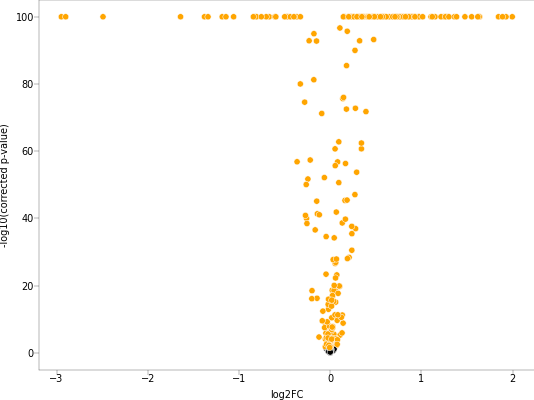

In [118]:
test_hyp_vs_pla.plot_volcano(
    corrected_pval=True, 
    min_fc=1, 
    alpha=0.05, 
    size=20,
    log10_p_threshold=-100,
)

In [119]:
test_hyp_vs_pla.summary()[(test_hyp_vs_pla.summary()['log2fc'] <= 0) &  (test_hyp_vs_pla.summary()['qval'] < 1e-20)]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
14,ANXA1,1.439402e-222,6.347242e-222,-0.461363,5.371339,False,False
15,ANXA2,0.000000e+00,0.000000e+00,-0.667805,5.320249,False,False
17,APP,1.797388e-309,9.818569e-309,-0.365542,5.116246,False,False
33,CAPG,1.218658e-37,2.654935e-37,-0.164282,0.448596,False,False
35,CAV1,0.000000e+00,0.000000e+00,-1.640486,1.713655,False,False
51,CD44,0.000000e+00,0.000000e+00,-0.821705,4.888044,False,False
54,CD68,0.000000e+00,0.000000e+00,-0.473621,0.261290,False,False
72,CHODL,1.840937e-42,4.237629e-42,-0.140434,0.232731,False,False
80,COL1A1,4.748604e-94,1.379356e-93,-0.230742,0.285359,False,False
85,CRYAB,0.000000e+00,0.000000e+00,-1.377607,5.483487,False,False


In [ ]:
#CD68 also negative at 2FC <= 0.4

In [31]:
test_hyp_vs_pla.summary()[(test_hyp_vs_pla.summary()['log2fc'] >= .75) &  (test_hyp_vs_pla.summary()['qval'] < 1e-20)]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
4,ADAMTS3,0.000000e+00,0.000000e+00,0.934425,0.810557,False,False
18,AQP4,1.158177e-295,6.143376e-295,0.920675,1.885750,False,False
25,BCAN,0.000000e+00,0.000000e+00,1.477701,2.242165,False,False
41,CCNB2,0.000000e+00,0.000000e+00,0.897036,0.980462,False,False
60,CDC20,0.000000e+00,0.000000e+00,1.551451,1.371302,False,False
66,CDK4,0.000000e+00,0.000000e+00,0.876589,2.022305,False,False
68,CEMIP2,0.000000e+00,0.000000e+00,1.105319,1.139254,False,False
69,CENPF,0.000000e+00,0.000000e+00,1.996659,2.867841,False,False
70,CEP70,0.000000e+00,0.000000e+00,0.967476,2.295555,False,False
78,CNTNAP3B,0.000000e+00,0.000000e+00,1.150390,1.546072,False,False


# Hypoxia + Plasma vs Hypoxia

In [102]:
adata_full.X = adata_full.layers['counts']

In [103]:
data = adata_full[adata_full.obs.time != '144h']

In [104]:

exp = pd.Categorical([l+'-'+c+'-'+t for l, c, t in zip(data.obs.line, data.obs.condition, data.obs.time)])
data.obs['Experiment'] = exp
cell_n = {e: (data.obs['Experiment']==e).sum() for e in data.obs['Experiment'].cat.categories}
organoid_size = np.array([cell_n[e] for e in data.obs['Experiment']])
#data.X = data.X / (1/organoid_size[:,np.newaxis]) * 1e4

/tmp/ipykernel_928514/1091497035.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs['Experiment'] = exp


In [105]:
# For plasma 
data_hyp_vs_hyppla = data[data.obs.condition.isin(['hyp', 'hyppla'])]
data_hyp_vs_hyppla  = anndata.AnnData(
    X=data_hyp_vs_hyppla.raw.X.toarray(),
    var=pd.DataFrame(index=data_hyp_vs_hyppla.var_names.values),
    obs=pd.DataFrame({'condition': np.array([0 if x == 'hyp' else 1 for x in data_hyp_vs_hyppla .obs.condition])})
)
sc.pp.normalize_total(data_hyp_vs_hyppla)
sc.pp.log1p(data_hyp_vs_hyppla)

test_hyp_vs_hyppla  = de.test.t_test(
    data=data_hyp_vs_hyppla ,
    grouping='condition',
    is_logged=True
)


/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [106]:
test_hyp_vs_hyppla.summary().to_parquet('DifferentialExpression_hyp_vs_hyppla.parquet')

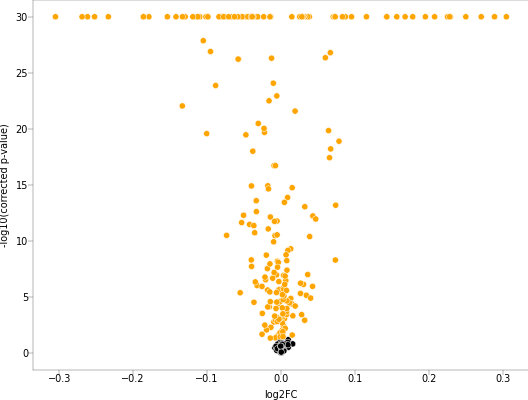

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,ABCC9,4.417034e-56,3.108912e-55,0.038142,0.057572,False,False
15,ANXA2,1.314282e-137,2.672374e-136,0.177899,2.392062,False,False
18,AQP4,9.500134e-173,3.160954e-171,0.270471,0.574028,False,False
31,C1orf162,6.308077e-23,2.623586e-22,0.018858,0.041316,False,False
51,CD44,6.648874e-240,4.055813e-238,0.304499,2.212362,False,False
55,CD74,5.907697e-102,7.722204e-101,0.228861,0.705024,False,False
70,CEP70,1.852315e-54,1.255458e-53,0.095158,0.512256,False,False
78,CNTNAP3B,1.828709e-95,2.231025e-94,0.115361,0.317881,False,False
103,DNER,7.875293e-247,5.764714e-245,0.156351,0.228142,False,False
105,EFHD1,2.515495e-66,2.245539e-65,0.070421,0.179268,False,False


In [120]:
test_hyp_vs_hyppla.plot_volcano(corrected_pval=True, min_fc=1, alpha=0.05, size=20,)
test_hyp_vs_hyppla.summary()[(test_hyp_vs_hyppla.summary()['log2fc'] >= 0) &  (test_hyp_vs_hyppla.summary()['qval'] < 1e-20)]

# Plasma vs HypoxiaPlasma

In [121]:
adata_full.X = adata_full.layers['counts']

In [122]:
data = adata_full[adata_full.obs.time != '144h']

In [123]:

exp = pd.Categorical([l+'-'+c+'-'+t for l, c, t in zip(data.obs.line, data.obs.condition, data.obs.time)])
data.obs['Experiment'] = exp
cell_n = {e: (data.obs['Experiment']==e).sum() for e in data.obs['Experiment'].cat.categories}
organoid_size = np.array([cell_n[e] for e in data.obs['Experiment']])
#data.X = data.X / organoid_size[:,np.newaxis] * 1e4

/tmp/ipykernel_928514/706975089.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs['Experiment'] = exp


In [124]:
# For plasma 

data_pla_vs_hyppla = data[data.obs.condition.isin(['pla', 'hyppla'])]
data_pla_vs_hyppla  = anndata.AnnData(
    X=data_pla_vs_hyppla.raw.X.toarray(),
    var=pd.DataFrame(index=data_pla_vs_hyppla.var_names.values),
    obs=pd.DataFrame({'condition': np.array([0 if x == 'pla' else 1 for x in data_pla_vs_hyppla .obs.condition])})
)
sc.pp.normalize_total(data_pla_vs_hyppla)
sc.pp.log1p(data_pla_vs_hyppla)

test_pla_vs_hyppla  = de.test.t_test(
    data=data_pla_vs_hyppla ,
    grouping='condition',
    is_logged=True
)


/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [125]:
test_pla_vs_hyppla.summary().to_parquet('DifferentialExpression_pla_vs_hyppla.parquet')

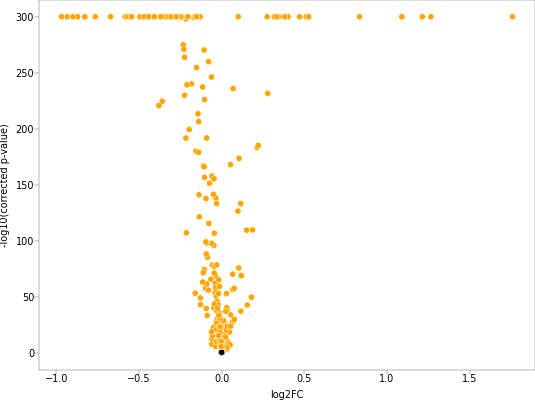

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
1,ACTA2,4.751475e-70,1.317455e-69,0.118401,0.831222,False,False
14,ANXA1,5.693407e-233,2.604733e-232,0.278645,2.285232,False,False
15,ANXA2,0.000000e+00,0.000000e+00,0.510887,2.308323,False,False
17,APP,0.000000e+00,0.000000e+00,0.317195,1.981899,False,False
31,C1orf162,4.642214e-27,9.284427e-27,0.020782,0.041925,False,False
33,CAPG,9.563673e-40,2.160682e-39,0.036837,0.092601,False,False
35,CAV1,0.000000e+00,0.000000e+00,0.320110,0.395876,False,False
46,CD274,2.688922e-23,5.152594e-23,0.019592,0.040002,False,False
51,CD44,0.000000e+00,0.000000e+00,0.834110,2.057456,False,False
54,CD68,0.000000e+00,0.000000e+00,0.100225,0.053541,False,False


In [129]:

test_pla_vs_hyppla.summary()[(test_pla_vs_hyppla.summary()['log2fc'] >= 0.0) &  (test_pla_vs_hyppla.summary()['qval'] < 1e-20)]

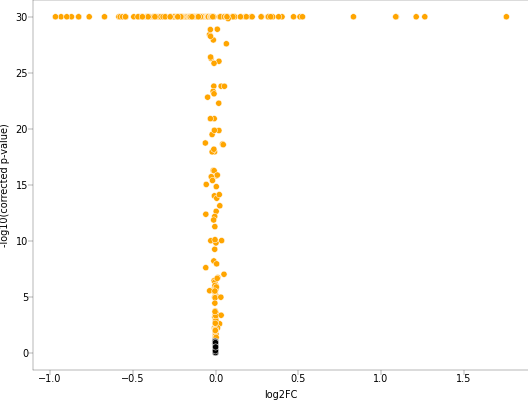

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
4,ADAMTS3,0.000000e+00,0.000000e+00,-0.266629,0.194126,False,False
25,BCAN,0.000000e+00,0.000000e+00,-0.584593,0.643079,False,False
60,CDC20,0.000000e+00,0.000000e+00,-0.420214,0.406953,False,False
66,CDK4,0.000000e+00,0.000000e+00,-0.299001,0.489107,False,False
68,CEMIP2,0.000000e+00,0.000000e+00,-0.344820,0.282237,False,False
69,CENPF,0.000000e+00,0.000000e+00,-0.827177,0.903314,False,False
101,DLL3,0.000000e+00,0.000000e+00,-0.332220,0.315982,False,False
104,EDNRB,0.000000e+00,0.000000e+00,-0.494124,0.713428,False,False
106,EGFR,3.209463e-222,1.398409e-221,-0.379137,1.487487,False,False
112,ERBB3,0.000000e+00,0.000000e+00,-0.397891,0.370789,False,False


In [127]:
test_pla_vs_hyppla.plot_volcano(corrected_pval=True, min_fc=1, alpha=0.05, size=20,)
test_pla_vs_hyppla.summary()[(test_pla_vs_hyppla.summary()['log2fc'] <= -.25) &  (test_pla_vs_hyppla.summary()['qval'] < 1e-20)]